In [480]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import yfinance as yf
import datetime as dt
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import itertools
import datetime as dt
import operator
from enum import Enum

In [488]:
from utils.calculations import N

In [466]:
gDaysInYear = 365.0  # .242
gSmall = 1e-12
gNotebookMode = False

INVROOT2PI = 0.3989422804014327

In [467]:
def N(x):
    """ Fast Normal CDF function based on Hull OFAODS  4th Edition Page 252.
    This function is accurate to 6 decimal places. """

    a1 = 0.319381530
    a2 = -0.356563782
    a3 = 1.781477937
    a4 = -1.821255978
    a5 = 1.330274429
    g = 0.2316419

    k = 1.0 / (1.0 + g * np.abs(x))
    k2 = k * k
    k3 = k2 * k
    k4 = k3 * k
    k5 = k4 * k

    if x >= 0.0:
        c = (a1 * k + a2 * k2 + a3 * k3 + a4 * k4 + a5 * k5)
        phi = 1.0 - c * np.exp(-x*x/2.0) * INVROOT2PI
    else:
        phi = 1.0 - N(-x)

    return phi

In [468]:
def bs_value(s, t, k, r, q, v, option_type_value):
    """ Price a derivative using Black-Scholes model. """

    if option_type_value == 'call':
        phi = 1.0
    elif option_type_value == 'put':
        phi = -1.0
    else:
        return 0.0

    k = np.maximum(k, gSmall)
    t = np.maximum(t, gSmall)
    v = np.maximum(v, gSmall)

    vsqrtT = v * np.sqrt(t)
    ss = s * np.exp(-q*t)
    kk = k * np.exp(-r*t)
    d1 = np.log(ss/kk) / vsqrtT + vsqrtT / 2.0
    d2 = d1 - vsqrtT

#    value = phi * ss * n_vect(phi * d1) - phi * kk * n_vect(phi * d2)
    value = phi * ss * N(phi * d1) - phi * kk * N(phi * d2)
    return value

In [469]:
def n_vect(x):
    return N(x)

In [470]:
def bs_delta(s, t, k, r, q, v, p_c):
    """ Price a derivative using Black-Scholes model. """

    if p_c == 'call':
        phi = +1.0
    elif p_c == 'put':
        phi = -1.0

    k = np.maximum(k, gSmall)
    t = np.maximum(t, gSmall)
    v = np.maximum(v, gSmall)

    vsqrtT = v * np.sqrt(t)
    ss = s * np.exp(-q*t)
    kk = k * np.exp(-r*t)
    d1 = np.log(ss/kk) / vsqrtT + vsqrtT / 2.0
    delta = phi * np.exp(-q*t) * n_vect(phi * d1)
    return delta

In [471]:
def get_mid_spread(df):
    
    spread = df['ask'] - df['bid']
    mid = df['bid'] + spread/2
    
    t_df = pd.concat([spread, mid], axis = 1)
    t_df.columns = ['spread', 'mid']
    
    return t_df

In [472]:
def exp_retrieve(name, thread_loop):
    
    try:
    
        tick = tickers.tickers[name]
        t_exp = pd.Series(tick.options, dtype=pd.StringDtype())
        
        t_loop = [x for x in itertools.product([tick], [name], t_exp)]
        
        thread_loop.extend(t_loop)
    
    except:
        
        pass

In [473]:
def option_retrieve(tick, name, exp):
    
    try:
    
        t_book = tick.option_chain(exp)
        t_calls = t_book.calls
        t_puts = t_book.puts
        
        t_calls['callput'] = 'call'
        t_puts['callput'] = 'put'
        
        t_chain = pd.concat([t_calls, t_puts])
        
        t_chain['expiry'] = exp
        t_chain['ticker'] = name
        t_chain['stock_px'] = px['Adj Close'][name].iloc[-1]
        t_chain['stock_ret'] = rets['Adj Close'][name].iloc[-1]
        
        t_chain.reset_index(drop=True, inplace=True)
        
    except:
        
        t_chain = pd.DataFrame()
    
    return t_chain

In [474]:
import numpy as np
from scipy.stats import norm


def bs_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)

def bs_put(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

def bs_vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

def find_vol(target_value, S, K, T, r, callput,*args):
    MAX_ITERATIONS = 100
    PRECISION = 1.0e-5
    sigma = 0.5
    for i in range(0, MAX_ITERATIONS):
        
        if callput == 'call':
            price = bs_call(S, K, T, r, sigma)
        else:
            price = bs_put(S, K, T, r, sigma)
        vega = np.max([bs_vega(S, K, T, r, sigma), 1])
        diff = target_value - price  # our root
        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega # f(x) / f'(x)
        
    #If mid price is messing with pricing, we get a vol that blows up to inf, just iterate 100 times and if not within reasonable range we drop
    
    if abs(sigma) > 1:
        
        sigma = np.nan
    
    return sigma

In [475]:
def get_delta_values(df):
    
    df_delta = df.copy()
    
    today_array = [dt.date.today().strftime('%Y-%m-%d')] * len(df_delta.index)
    df_delta['k_norm'] = df_delta['strike'] / df_delta['stock_px']
    df_delta['1d_delta'] = df_delta['change'] / 100 / df_delta['stock_ret']
    df_delta['t_exp'] = np.busday_count(today_array, [x for x in df_delta['expiry']])
    
    df_delta[['spread', 'mid']] = get_mid_spread(df_delta)

    df_delta['vol_calc'] = df_delta.apply(lambda x: find_vol(x.mid, x.stock_px, x.strike, x.t_exp, 0.01, x.callput), axis= 1)
    df_delta['delta_yahoo'] = df_delta.apply(lambda x: bs_delta(x.stock_px, x.t_exp/252, x.strike, 0, 0, x.impliedVolatility, x.callput), axis = 1)
    df_delta['delta_calc'] = df_delta.apply(lambda x: bs_delta(x.stock_px, x.t_exp/252, x.strike, 0, 0, x.vol_calc, x.callput), axis = 1)
    
    return df_delta

In [404]:
N = norm.cdf

test_chain = get_delta_values(opt_chain)
test_chain = test_chain[test_chain['callput'] == 'call']

In [426]:
check = pd.concat([test_chain[(test_chain['ticker'] == 'AMZN') & (test_chain['expiry'] == '2023-01-20')][['delta_calc', 'vol_calc', 'k_norm']].set_index('k_norm'), 
           test_chain[(test_chain['ticker'] == 'AAPL') & (test_chain['expiry'] == '2023-01-20')][['delta_calc', 'vol_calc', 'k_norm']].set_index('k_norm')], axis =1)

In [419]:
test_chain[(test_chain['ticker'].isin(['AMZN', 'AAPL'])) & (test_chain['expiry'] == '2023-01-20')][['delta_calc', 'vol_calc', 'k_norm']]

,delta_calc,vol_calc,k_norm
437,NaN,NaN,0.231446
438,NaN,NaN,0.270020
439,0.999897,1.754924,0.308594
440,1.000000,0.979609,0.385743
441,1.000000,0.857406,0.424317
...,...,...,...
5918,NaN,NaN,59.247211
5919,NaN,NaN,60.408921
5920,NaN,NaN,61.570631
5921,NaN,NaN,62.732341


<AxesSubplot: xlabel='k_norm'>

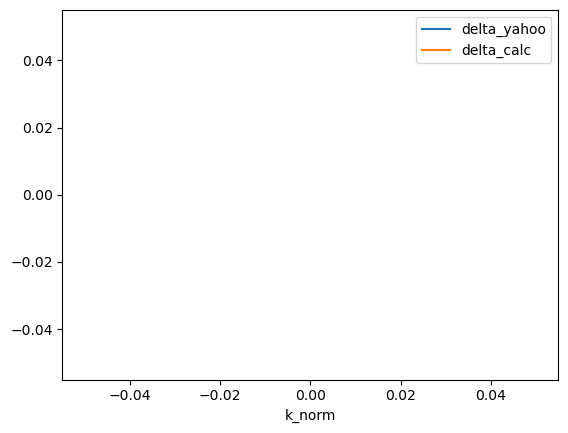

In [397]:
test_chain[(test_chain['ticker'] == 'AMZN') & (test_chain['expiry'] == '2023-01-20')][['delta_yahoo', 'delta_calc', 'k_norm']].set_index('k_norm').loc[0.8:1.2].plot()

In [10]:
html = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = BeautifulSoup(html.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})

In [11]:
stock_data = pd.read_html(str(table))[0]

In [12]:
delta_t = pd.tseries.offsets.BusinessDay(n = 21)
end_date = dt.date.today()
start_date = end_date - delta_t

In [13]:
names = [name.replace(".", "-") for name in stock_data.Symbol]
name_query = " ".join(names)

In [463]:
px = yf.download(name_query, start=start_date)
rets = px.pct_change(1)

[*********************100%***********************]  503 of 503 completed


In [15]:
tickers = yf.Tickers(name_query)

In [490]:
thread_count = 10
name_count = 10

thread_loop = []

with ThreadPoolExecutor(thread_count) as executor:
    futures = [executor.submit(exp_retrieve, name, thread_loop) for name in names[:name_count]]
    
with ThreadPoolExecutor(thread_count) as executor:
    futures = [executor.submit(option_retrieve, tick, name, exp) for tick, name, exp in thread_loop]
    
opt_chain = pd.concat([future.result() for future in futures]).sort_values(['ticker', 'expiry']).reset_index(drop = True)

/var/folders/k2/d2y9gjxs0jz7tm_dt0tv243m0000gn/T/ipykernel_57603/2570180908.py:12: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  t_chain = pd.concat([t_calls, t_puts])


In [491]:
opt_chain

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,callput,expiry,ticker,stock_px,stock_ret
0,AAP230113C00130000,2022-12-02 16:11:26+00:00,130.0,19.80,16.60,18.00,0.00,0.000000,8.0,0.0,0.000010,True,REGULAR,USD,call,2023-01-13,AAP,154.020004,0.005615
1,AAP230113C00135000,2022-12-21 16:10:07+00:00,135.0,8.50,19.70,20.30,0.00,0.000000,NaN,1.0,0.840822,True,REGULAR,USD,call,2023-01-13,AAP,154.020004,0.005615
2,AAP230113C00140000,2023-01-05 20:59:17+00:00,140.0,13.27,14.40,15.40,0.00,0.000000,1.0,11.0,0.629398,True,REGULAR,USD,call,2023-01-13,AAP,154.020004,0.005615
3,AAP230113C00144000,2023-01-04 14:54:46+00:00,144.0,9.20,10.60,11.40,0.00,0.000000,NaN,0.0,0.519048,True,REGULAR,USD,call,2023-01-13,AAP,154.020004,0.005615
4,AAP230113C00145000,2023-01-09 15:10:25+00:00,145.0,9.05,9.60,10.50,-0.42,-4.435059,4.0,22.0,0.600102,True,REGULAR,USD,call,2023-01-13,AAP,154.020004,0.005615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6222,MMM250117P00170000,2022-12-13 18:56:59+00:00,170.0,45.30,44.45,45.85,0.00,0.000000,2.0,3.0,0.220406,True,REGULAR,USD,put,2025-01-17,MMM,126.720001,0.030579
6223,MMM250117P00175000,2022-11-25 16:18:19+00:00,175.0,46.92,54.50,58.25,0.00,0.000000,2.0,11.0,0.350592,True,REGULAR,USD,put,2025-01-17,MMM,126.720001,0.030579
6224,MMM250117P00185000,2022-11-04 19:29:36+00:00,185.0,62.00,57.15,59.95,0.00,0.000000,1.0,3.0,0.239815,True,REGULAR,USD,put,2025-01-17,MMM,126.720001,0.030579
6225,MMM250117P00190000,2022-12-08 18:18:30+00:00,190.0,63.97,62.55,66.20,0.00,0.000000,1.0,2.0,0.275184,True,REGULAR,USD,put,2025-01-17,MMM,126.720001,0.030579


In [ ]:
cleaned_chain = get_delta_values(opt_chain)

In [18]:
cleaned_chain.groupby(['ticker', 'expiry'])['volume'].sum().sort_values

ticker  expiry    
NWS     2023-01-20        0.0
HRL     2023-12-15        0.0
PEAK    2023-12-15        0.0
MLM     2023-06-16        0.0
ANSS    2023-12-15        0.0
                       ...   
F       2023-01-20    25679.0
META    2023-01-20    26936.0
NFLX    2023-01-20    28021.0
BMY     2024-01-19    28329.0
AAPL    2023-01-20    35494.0
Name: volume, Length: 1396, dtype: float64

In [27]:
cleaned_chain[(cleaned_chain['ticker'] == 'AAPL') & (cleaned_chain['expiry'] == '2023-01-20') & (cleaned_chain['callput'] == 'call')]['impliedVolatility']

437     0.000000
438     0.000000
439    29.218751
440    16.509770
441    14.519532
442    13.042971
443    11.886721
444    10.902347
445    10.062992
446     9.305668
447     8.676518
448     8.079595
449     7.544678
450     7.049318
451     6.586916
452     6.161623
453     5.761477
454     5.391605
455     5.047123
456     4.724125
457     4.416264
458     4.128667
459     3.855469
460     3.595704
461     3.351564
462     3.133181
463     2.915530
464     2.722904
465     2.547123
466     2.386723
467     2.244145
468     2.121343
469     2.005864
470     1.914063
471     1.832032
472     1.763185
473     1.708498
474     1.667970
475     1.627932
476     1.603518
477     1.585940
478     1.570315
479     1.568362
480     1.562502
481     1.558596
482     1.574221
483     1.566408
484     1.593752
485     1.593752
Name: impliedVolatility, dtype: float64

In [433]:
ticks = [name for name in cleaned_chain.groupby('ticker')['volume'].sum().sort_values(ascending=False)[:20].index]

In [443]:
rebase_index = np.arange(0.8,1.21,0.01)
smaller_index = np.arange(0.9,1.11,0.01)

In [449]:
d_curve = test_chain[(test_chain['ticker'].isin(ticks)) & (test_chain['expiry'] == '2023-01-20') & (test_chain['callput'] == 'call')]

In [454]:
d_curve

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,...,stock_px,stock_ret,k_norm,1d_delta,t_exp,spread,mid,vol_calc,delta_yahoo,delta_calc
125,AAL230120C00003000,2022-07-28 17:58:26+00:00,3.0,10.65,12.00,12.10,0.000000,0.00000,1.0,844.0,...,14.180000,0.013581,0.211566,0.000000,9,0.10,12.050,0.522992,0.961010,1.0
126,AAL230120C00005000,2022-08-10 14:43:21+00:00,5.0,10.35,10.05,10.20,0.200001,1.97045,1.0,425.0,...,14.180000,0.013581,0.352609,0.147263,9,0.15,10.125,0.341640,0.927938,1.0
127,AAL230120C00007000,2022-08-04 13:34:16+00:00,7.0,8.10,8.20,8.35,0.000000,0.00000,NaN,65.0,...,14.180000,0.013581,0.493653,0.000000,9,0.15,8.275,0.247851,0.887973,1.0
128,AAL230120C00008000,2022-08-10 17:21:48+00:00,8.0,7.55,7.30,7.40,0.400000,5.59441,1.0,1431.0,...,14.180000,0.013581,0.564175,0.294525,9,0.10,7.350,0.211871,0.864220,1.0
129,AAL230120C00009000,2022-08-10 19:16:03+00:00,9.0,6.58,6.45,6.55,0.380000,6.12903,5.0,61.0,...,14.180000,0.013581,0.634697,0.279799,9,0.10,6.500,0.190185,0.835371,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72961,WFC230120C00067500,2022-08-02 14:06:56+00:00,67.5,0.06,0.07,0.09,0.000000,0.00000,2.0,561.0,...,42.799999,0.008958,1.577103,0.000000,9,0.02,0.080,0.060993,0.029837,0.0
72962,WFC230120C00070000,2022-08-11 17:24:09+00:00,70.0,0.07,0.05,0.07,0.010000,16.66670,82.0,7390.0,...,42.799999,0.008958,1.635514,0.011163,9,0.02,0.060,0.063125,0.023171,0.0
72963,WFC230120C00075000,2022-08-10 19:07:08+00:00,75.0,0.03,0.03,0.08,0.000000,0.00000,12.0,6207.0,...,42.799999,0.008958,1.752336,0.000000,9,0.05,0.055,0.071110,0.019935,0.0
72964,WFC230120C00080000,2022-08-09 19:51:22+00:00,80.0,0.02,0.00,0.03,0.000000,0.00000,3.0,930.0,...,42.799999,0.008958,1.869159,0.000000,9,0.03,0.015,0.067830,0.006905,0.0


In [455]:
curves = pd.DataFrame()

curve_df = pd.DataFrame(columns = ticks, index = rebase_index)

for tick in ticks:
    
    t_curve = d_curve[d_curve['ticker'] == tick][['k_norm', 'vol_calc']].set_index('k_norm')

    interp_curve = pd.DataFrame(np.interp(rebase_index, t_curve.index, t_curve.vol_calc), index = rebase_index)

    curve_df[tick] = interp_curve

<AxesSubplot: >

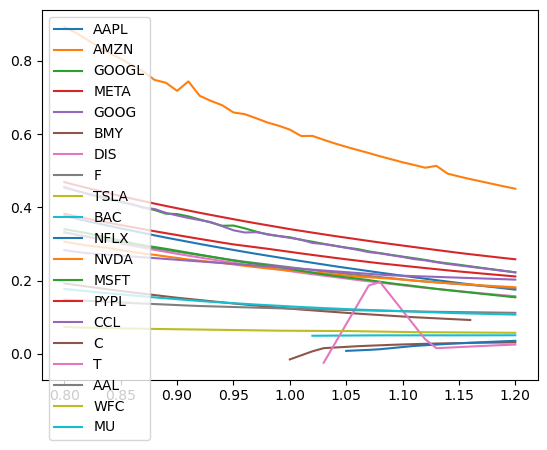

In [456]:
curve_df.plot()